# Purpose/Introduction
The purpose of this Notebook is to show an example of how to use the Python programming language to inspect new data for potential errors, what is often called Exploratory Data Analysis, or EDA. 

This Notebook shows preliminary data cleaning/integrity checks for simulated temperature time series data. 

**The scenario:** You are working on a study of building temperatures across the San Francisco Bay Area. As part of that study, you have received some data from a state agency that covers 10 buildings over the last ten years. Each building is located in a different Bay Area city and is used for offices, and had employees attending work during the ten year period. 

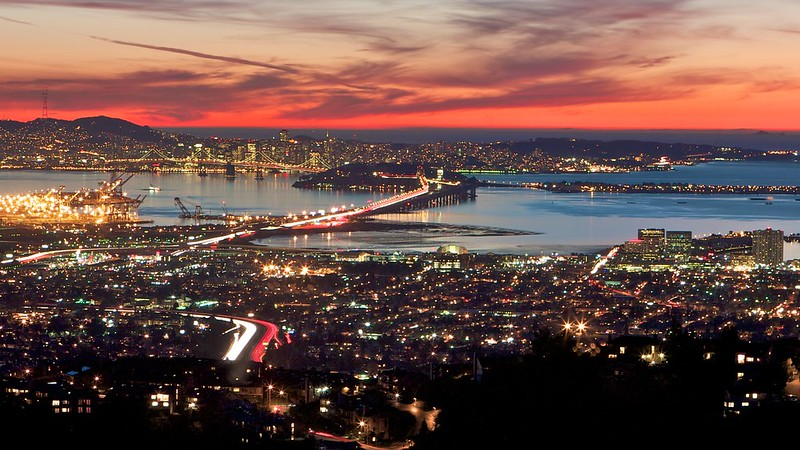

Picture credit: [--Mark--](https://www.flickr.com/people/34186459@N00/), [Usage License](https://creativecommons.org/licenses/by-nc-sa/2.0/)

The data come to you in an Excel file (.xlsx format). The three columns are the date of collection (year-month-day), the temperature in &deg;C, and the location (city) of the building where the temperature reading was taken. There are roughly 10,000 rows in the Excel file, and the file itself is under 300k.

We received the date on 8 March 2023. The state agency tells us that the last temperature measurements were taken on 7 March 2023. The data are delivered out of date order. Also, your contact at the state agency tells you that the actual readings were taken in &deg;F, and converted to &deg;C. The conversion was done by an intern with an Excel script, but the intern is no longer with the agency and your contacts at the state agency are looking for the script. They think that they might be able to find it in a few weeks. In the meantime you dig into the data. 


# General Steps of Data Cleaning
1. Identify the columns of interest
1. For each column
  * Identify the type of data that should be there -- discipline specific
  * Identify the desired format(s) 
  * Descriptive Statistics
    * For continuous/numerical data identify descriptive stats, i.e. max, median, mean etc.
    * For categorical data get a values count
1. Decide what to do with problematic data identified in the above steps. 
1. Decide what tool(s) to use to perform subsequent analysis
1. Visualization of data that conforms to required formats
  * Our goal here is to get to visualization ASAP so that we can get an idea of the shape of the data with minimal processing
  * For time series, show line charts
  * For categoricals, get value counts histogram






# Identify the Columns of Interest

First, read in the data so you can work with it in a Notebook. Since the data is pretty small at under 300 kb, you can load it into memory without a problem. The right choice here is probably `pandas`, which is a Python module. From a cursory inspection of the Excel file, you can see that there are three columns:
1. `date`
2. `city`
3. `temp_c`

The first two columns are self explanatory. The third column looks like it will probably be the temperature in &deg;C. 




In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from pathlib import Path


In [ ]:
file_name = 'temps_premade.xlsx'
path = Path(file_name)
# Read in the Excel file 
# Specify the columns you're interested in, otherwise sometimes you get the index column of the Excel file. 
df = pd.read_excel(path, usecols=['date', 'city', 'temp_c'])


In [ ]:
df.head()

# `date` Column Format
It is supposed to be a year-month-day format, but there seems to be a time associated with the first few entries. When looking at the Excel file, there is only a year-month-day format. It seems likely that the times are an artifact of the `pandas` importation process. Make a note to fix this later.

What is the format of the column? 

In [ ]:
df.applymap(type).apply(pd.value_counts).fillna(0)

Here we see that 100 rows have a class type of `str`, while the rest are in the `datetime` class. This indicates that there is a problem with those rows of some sort. 

Let's see what the columns look like in the rows of class type `str`. Since there are only 100 of them, it's feasible to look at all example rows. 

In [ ]:
str_dates = df[df['date'].apply(lambda x: isinstance(x, str))]


In [ ]:
# This sets the default display for pandas dataframes at 100 rows
pd.options.display.max_rows =100 
str_dates


In [ ]:
# Reset max rows
pd.options.display.max_rows = 60

## Comment
It looks like the 100 rows of strings in the `date` column are pretty garbled. More than just the `date` column -- all the columns look scrambled. It is also the last 100 rows, going by the indices. 

It is probably safe to say that the 100 rows should be excluded from the data set when it comes time to do the visualization exploration portion of the analysis. 

We expect to see `datetime` objects or at least strings that are properly formatted for a date. 

## Descriptive Statistics
We will have to remove the 100 scrambled rows so we can determine some descriptive statistics for the `date` column

In [ ]:
df_date = df.copy()
df_date_drop = df_date.drop(labels=str_dates.index)
# Check to make sure that the str type rows are actually gone
df_date_drop.applymap(type).apply(pd.value_counts).fillna(0)

Now that we have removed the non-`datetime` rows, we can proceed with some descriptive statistics for the `date` column.

### `date` Column Questions
1. What is the latest date?
2. What is the earliest date?
3. What is the most common date that appears in the data?


In [ ]:
# Make sure everything is a datetime object
df_date_drop.date = pd.to_datetime(df_date_drop.date, format="%d/%m/%Y")

## 1. *What is the latest date?*

In [ ]:
# Latest date
df_date_drop['date'].max()

## 2. *What is the earliest date?*

In [ ]:
# Earliest date
df_date_drop['date'].min()

In [ ]:
df_date_drop['date'].describe()

In [ ]:
df_date_drop.info()

In [ ]:
df_date_drop

## What is the distribution of the dates? 


In [ ]:
pd.options.display.max_rows = 100
df_date_drop.groupby(df_date_drop['date'].dt.year).count()


In [ ]:
# We converted to date objects so we can easily use math operators on the dates, e.g. 1825-11-24
df_bad_dates = df_date_drop[df_date_drop['date'].dt.year <2013]

In [ ]:
# Make sure this really selected the older dates
df_bad_dates.head()

In [ ]:
df_bad_dates.count()

## Comment

The earliest date is in 1825.
The latest date is in April 2023.

Given that the data was received on 8 March 2023, the latest date is clearly erroneous. 

Given that the data is supposed to be for the last 10 years, the earliest date is clearly erroneous as well. 

A quick count of the dates shows the majority of dates are within the last ten years (as expected). There are 81 dates before 2013, and these are clearly erroneous since the data are supposed to be from the last ten years only. 

# `city` Column Format
As seen above, the `city` column is all `str` values, which is what we expect since it is city names. 

## Descriptive Statistics
### Questions 
1. Do we know what cities are expected in the values?
2. What are the counts for each city? 

### 1. *Do we know what cities are expected in the values?*
Yes, according to the government agency that collected the data, we should have data for the following cities:
1. Berkeley
1. Oakland
1. San Leandro
1. San Francisco
1. Richmond
1. Antioch
1. Albany
1. Novato
1. Morgan Hill
1. San Jose

## 2. *What are the counts for each city?*

In [ ]:
df.city.describe()


In [ ]:

df.city.value_counts()

In [ ]:

###

### Comment
We see that there are 110 discrete city names. There should be 10 city names according to our information from the state agency. We need to look deeper into this problem. 

In [ ]:
# Display all the value counts for the city column
pd.set_option("display.max_rows", None)
df.city.value_counts()

In [ ]:
pd.set_option("display.max_rows", 50)


## Comment
Here we can see the top 10 strings in the `cities` column are indeed the ten cities on the list from the state agency. The other 100 appear to be scrambled versions of the cities in the top 10. 

For the 100 rows we looked at in the `city` analysis the dates seemed to be scrambled, so this is consistent. 

# `temp_c` Column Format
As we saw in Cell 23 with the `date` column analysis the format for `temp_c` is a `float`. 

## Descriptive Statistics
### Questions 
1. Do we have an expected range for the `temp_c`?
1. What are the units for `temp_c`?
1. Can we get the percentile distribution of `temp_c`?


### 1. *Do we have an expected range for the `temp_c`?*
We did not receive an expected range for building temperature. Based on a cursory look at Bay Area temperature records, we would expect that the buildings never go below -10&deg;C or above, say 50&deg;C. If we wanted to be more accurate, we could look at the low/high temperature records for the last 10 years for each city in the data. 

### 2. *What are the units for `temp_c`?*
&deg;Celsius



### 3. *Can we get percentile distribution of `temp_c`?*


In [ ]:
df.temp_c.describe()

### Comment
There are clearly some problems with the temperature data when the maximum temperature is 9.9x10<sup>16</sup>&deg;C, and the standard deviation is 1.8x10<sup>15</sup>&deg;C.
However the 50th percentile value is ~20&deg;C, with a 75th percentile value of ~21&deg;C. Both of those seem like reasonable indoor temperatures for buildings, and this likely indicates that the large maximum value seen is probably an erroneous outlier. 

# Problematic Data
In the analysis of the `date` and `city` columns, it became apparent that ~100 rows had scrambled, nonsensical data. It makes sense to remove that data for now, given that it is 1% of the data. At a later step, we can determine if the data is salvagable. 

If we want to do timeseries plots by city, for example, removing the scrambled city names is important to get an accurate picture of what we have.

Additionally, we should remove the dates before 2013 from the current analysis. At a later time we can follow up with the data collection/export process and see why there are 81 dates before 2013. Also, if we keep in the 81 pre-2013 dates it will make the time series plots difficult to parse, because there are relatively few points.

What about the temperature data above the 75th percentile? We can keep that in for now just to see how numerous the outliers are -- a visual inspection of plots can often help identify trends that create outliers. 

In [ ]:
df_for_visualization = df_date_drop.drop(labels=df_bad_dates.index)


*What do the temperatures in the scrambled rows look like?*
---
Maybe the rows we identified as having scrambled `city` and `date` data are the ones throwing off the temperature statistics as well? 



In [ ]:
str_dates.head()


In [ ]:
str_dates.describe()

### Comment
It looks like the 100 rows of scrambled data are the origin of the disparate descriptive statistics, since the mean is 4.4x10<sup>15</sup>&deg;C, with a 50th percentile value of 1.0x10<sup>9</sup>&deg;C, and a max of 9.91x10<sup>16</sup>&deg;C. Let's take the data with the 100 scrambled rows removed and run the `describe` function again. 

In [ ]:
df_date_drop.describe()


### Comment
After removing the 100 rows with scrambled `date` and `temp_c` values, we can see that the descriptive statistics for `temp_c` are a little more sane, with a mean value of 20.26&deg;C. The 50th and 75th percentile values are near 20&deg;C, but there is still a max value that is likely erroneous. The max value is ~126&deg;C, clearly an unrealistic temperature for an occupied office building. 

# Subsequent Analysis/Tools
In subsequent analysis we will visualize the data using the Python module `matplotlib`. To prepare the data we will continue to use `pandas` to sort the data -- however, this is a good place to note that some kind of SQL would be right if if the data were larger than the amount of RAM on your machine, to avoid having to load everything into memory. Also, SQL queries can be easier to write and read than `pandas` when we want to sort the data for various views. 



# Visualization 
Initial visualization can be helpful in detecting anomalies and general exploration here:
1. Bar chart of cities 
1. Distribution of dates
1. Histogram of temperature values
1. Time series graph of temperature for each city


## Bar Chart of City Counts

In [ ]:
city_counts = df_for_visualization.city.value_counts()
city_counts.plot(x=city_counts.index, kind='bar')
plt.show()

## Histograms of `temp_c`
Temperature data in &deg;C.

In [ ]:
df_for_visualization.temp_c.plot(kind='hist')
plt.show()

In [ ]:
#There appear to be mostly values around 20, and then a couple values around 60, then at least one at 120.
print(f'99.3th percentile is {df_for_visualization.temp_c.quantile(.99)}')
print(f'99.9th percentile is {df_for_visualization.temp_c.quantile(.999)}')

In [ ]:
df_for_visualization_99 = df_for_visualization[df_for_visualization.temp_c <= df_for_visualization.temp_c.quantile(.99)]

In [ ]:
df_for_visualization_99.plot(kind='hist')
plt.show()

### Comment
Above we can see that threre is a roughly bell shaped distribution of data centered around 20, once we only look at data up to the 99th percentile. This indicates that values above 24 are outliers -- the question is, are the outliers the result of some underlying event in the buildings, or are they artifacts of the data collection/transformation process?

In [ ]:
df_date_drop_above_99 = df_for_visualization[df_for_visualization.temp_c > df_for_visualization.temp_c.quantile(.99)]

In [ ]:

df_date_drop_above_99.temp_c.describe()

In [ ]:
df_date_drop_above_99.plot(kind='hist')
plt.show()

### Comment
The plot above shows the 99th percentile data from `temp_c`. We can see that there are around 40+ data points with temperatures in the 20&deg;C to 30&deg;C range which seems reasonable. However, there is also a cluster of ~50 data points with temperatures between 65&deg;+ to 70&deg;, with a few outliers around 120&deg;C. This would seem to indicate that there is the expected distribution represented by the 99th percentile data, and some other data generating events that create the two outlier regimes. 

## Time Series Plots

In [ ]:
# What if we just jumped straight to visualization? 

berkeley_df = df_date_drop[df_date_drop['city']=="Berkeley"].copy()
berkeley_df = berkeley_df.sort_values(by=['date'])
date = berkeley_df['date']
value = berkeley_df['temp_c']

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(date,value)
plt.show()

### Comment
As we can see above, if we visualize the time series data without removing the pre-2013 dates, the plot is very crowded during our actual time of interest, i.e. 2013-2023. This is because there are relatively few pre-2013 (erroneous) dates. That is why we removed the erroneous pre-2013 values, so our plot would show us more detail on the interval of interest, 2013-2023.


In [ ]:
berkeley_df = df_for_visualization[df_for_visualization['city']=="Berkeley"].copy()
berkeley_df = berkeley_df.sort_values(by=['date'])
date = berkeley_df['date']
value = berkeley_df['temp_c']
month_year_formatter = mdates.DateFormatter('%b, %Y') # The "," is intentional.
fig, ax = plt.subplots(figsize=(8,6))
monthly_locator = mdates.MonthLocator()
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.plot(date, value)
fig.autofmt_xdate()
ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_title('Berkeley')
ax.plot(date,value)
plt.show()

### Comment
As we can see above once we remove the pre-2013 data points, we can "zoom in" on our period of interest. 

During the period of interest (2013-2023) the temperature measurements hovered around 20&deg;C, with a few outliers that spiked to as high as 120&deg;+. 

### Systematic Visualization

We have a plot for Berkeley, but what about the other 9 cities? If we want to look for outliers, we will have to make 9 more plots. It will become difficult to make systematic changes to the plot if we make each with separate code. The answer is to make some functions that can run through the dataframe and systematically generate the plots of interest. 

That way, if we want to tweak the layout of the plot, we edit one piece of code and the changes will propagate to all plots. 

In [ ]:
[* df_for_visualization.city.unique()]

In [ ]:
class MultiCityPlot:

  def __init__(self, data):
    """
    data should be a pandas dataframe
    """
    self.data = data


  def plot_time_series(self, title, date_column, value_column):
     # Sets date labels on plot as Month, Year
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    # Sets up object for plot and its axes
    # fig, ax = plt.subplots(figsize=(8,6))
    fig, ax = plt.subplots()
    # Set up where the tick marks and labels will go 
    monthly_locator = mdates.MonthLocator()
    # Make a 6 month interval 
    half_year_locator = mdates.MonthLocator(interval=6)
    # Set the large ticks on the x axis at the 6 month interval created above
    # This will put labels at the 6 month interval
    ax.xaxis.set_major_locator(half_year_locator)
    # Sets small ticks  set at a monthly level
    ax.xaxis.set_minor_locator(monthly_locator)
    # Sets the output format of the month, and year 
    ax.xaxis.set_major_formatter(month_year_formatter)
    # Fixes the date labels to display properly on the x-axis    
    fig.autofmt_xdate()
    ax.set_ylabel("Temperature ($^\circ$C)")
    ax.set_title(title)
    ax.plot(date_column,value_column)
    plt.show()

  def plot_one_city_temps(self,city_name):
    """
    Makes one time series plot of temps for one city
    """
    city_df = self.data[self.data['city']==city_name].copy()
    sorted_city_df = city_df.sort_values(by=['date'])
    date = sorted_city_df['date']
    value = sorted_city_df['temp_c']
        # Sets date labels on plot as Month, Year
    self.plot_time_series(title=city_name,
                          date_column=date,
                          value_column=value)
    
  def get_all_cities(self):
    cities = [* self.data.city.unique()]
    return cities

  def make_multiple_temp_plots(self):
    """
    Makes individual plots for city temps time series
    """
    cities = self.get_all_cities()
    for i in cities:
      self.plot_one_city_temps(city_name=i)
    
  def make_one_all_city_plot(self):
    """
    Plots all cities on one plot 
    """
    # sort all data by date
    sorted_df = self.data.sort_values(by=['date'])
    # Plot it on one chart titled "all data in time order"
    self.plot_time_series(title='All Temperatures',
                          date_column=sorted_df['date'],
                          value_column=sorted_df['temp_c'])

    
  

In [ ]:
plotter = MultiCityPlot(df_for_visualization)
plotter.make_multiple_temp_plots()

### Comment
There are several things that become apparent from the above plots:
1. We have future dates in several plots, since there are data points for August, September, and October of 2023. This is clearly erroneous and should be removed from consideration until we can ascertain the cause. We apparently forgot to remove the future dates so far, and the charts give us a good way to spot check our process. 
2. Most of the data hovers around 20&deg;C, which is what we expect from descriptive statistics calculated earlier.
3. For each city plot, we have a handful of outliers, with most falling into the 60&deg;-70&deg; range, and a few arround 120&deg;.

There isn't much we can do to remedy the future dates with the knowledge we have of the data transformation process before we received it, so we should remove future dates and make the plots again. 

In [ ]:
cutoff = dt.date(2023,3,7)
future_dates = df_for_visualization[df_for_visualization.date.dt.date > cutoff]
future_dates.describe()


### Comment:
We can see above that 159 rows have dates in the future, i.e. after the date of last collection on 7 March 2023. The descriptive statistics of the future date rows appear to be similar to the rest of the data, broadly. 

In [ ]:
df_for_visualization_a = df_for_visualization.drop(future_dates.index)

In [ ]:

df_for_visualization_a.date.max()

In [ ]:

df_for_visualization_a.date

In [ ]:
plotter2 = MultiCityPlot(df_for_visualization_a)
plotter2.make_multiple_temp_plots()

### Comment
Now we see plot lines cut off in March, though in some cases the major x-axis labels still exist for April or May. Note also that it was easy for us to make the plots by just calling the class functions we wrote previously. If we had not made the class functions we would have had to cut and paste the code for each chart 10 times -- too much work!

The 60&deg;-80&deg; outliers still exist as do the 120&deg; outliers. 

In [ ]:
plotter2.make_one_all_city_plot()

### Comment
The all-cities plot shows about what we expect by now -- most measurements hovering around 20&deg;C, and some excursions to the ~60&deg;-80&deg;, with two outliers of ~120&deg;. The data also cuts off in March, with the April label on the x-axis still appearing. 

The question is, what is the source of the outlier regimes? 

One possibility is that the thermometers had an intermittent problem causing them to read higher than otherwise. Another possibility is that the 60&deg;-80&deg; regime is the result of a failed conversion from &deg;F to &deg;C, since we know that the data were collected in Farenheit, and then converted using some kind of Excel macro. Perhaps the macro missed some data points during the conversion process. We know that somewhere in the conversion process the data for temps, cities, and dates got scrambled -- perhaps there was a problem with the conversion from Farenheit to Celsius as well. 

A range of 60&deg;-80&deg;F would convert to ~15&deg;- 27&deg;C. Let's run a Farenheit to Celsius conversion on data that falls in the 60&deg;-80&deg; range and see what happens to the plots and summary statistics. 

In [ ]:
def f_to_c(deg_f):
     """
     x is temp in degrees F
     """ 
     c_temp = (deg_f-32) * 5/9
     return c_temp

In [ ]:
# Applying the conversion
# We give a slightly lower boundary than 60 and a slightly higher boundary than 80, since the plots appear close to 60 and 80
df_for_visualization_a.temp_c = df_for_visualization_a.temp_c.apply(lambda x: f_to_c(x) if x>58 and x<82 else x)

In [ ]:
plotter2 = MultiCityPlot(df_for_visualization_a)
plotter2.make_multiple_temp_plots()

In [ ]:
plotter2.make_one_all_city_plot()


### Comment
Once we ran the ~60&deg;-80&deg; regime against a Farenheit to Celsius converter, the data smoothed out and fit in with the majority of existing temperature data. 

We can now go back to the state agency and ask to look into the process that generated the temperature data with some questions:
1. Assuming that they found the script since our last contact, how did the macro run that converted the data from Farenheit to Celsius? 
2. Was there something wrong with the thermometers in the cities? 

As to the scrambled rows, you should consider whether it's worthwhile to try to unscramble the data. It looks like the  letters are all there for the cities, just in the wrong order. If the data are valuable it may be worthwhile to develop some kind of algoritihm to unscramble the data. 

If the state agency cannot find the Excel script, then we should consider whether to 
just drop the data points from the ~60&deg;-80&deg; regime

*OR alternatively*

Apply the &deg;F to &deg;C conversion against the 60-80 data, then use formal statistical inference tools to compare the resulting distribution to the data centered around 20&deg;, and decide to keep/drop the data based on the outcome of the inference results. 

We still have two outliers at ~120&deg;C, one found in Berkeley and the other in Albany. It would probably worthwhile to heavily scrutinize the data collection pipeline for those specific stations, to see if there was an instrument or software failure. 